# Stripe merchant churn 

**Contents:**
<ol>
<li>Data Preprocessing</li>
 <li>Creating new variables</li>
    <li>Merchant segmentation</li>
    <li>Merhant churn analysis</li>
    <li>Predicting merchant churn</li>
<ol>

### 1.Data Preprocessing

In [1]:
#importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import copy
import datetime
import plotly.express as px
sns.set(color_codes=True)
from dateutil import parser
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.spatial.distance import cdist

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [331]:
#Loading the dataset
data = pd.read_csv('C:/Users/apoor/Desktop/Apoorva/Stripe/takehome_ds_written.csv', encoding = "ISO-8859-1")
data.head()

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203


In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Unnamed: 0           1513719 non-null  int64 
 1   merchant             1513719 non-null  object
 2   time                 1513719 non-null  object
 3   amount_usd_in_cents  1513719 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 46.2+ MB


There are no null values in the dataset. Hence, we do not require null treatment in this dataset.

Since, we have transaction amount in cents, we will convert amount from cents to dollars and we will also create another column called date, as we have multiple transactions in single day.

In [333]:
#adding new columns-usd and date
data['usd']=data['amount_usd_in_cents']/100
data['date']=data['time'].str[:10]
data

,Unnamed: 0,merchant,time,amount_usd_in_cents,usd,date
0,1,faa029c6b0,2034-06-17 23:34:14,6349,63.49,2034-06-17
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854,38.54,2034-12-27
2,3,5608f200cf,2034-04-30 01:29:42,789,7.89,2034-04-30
3,4,15b1a0d61e,2034-09-16 01:06:23,4452,44.52,2034-09-16
4,5,4770051790,2034-07-22 16:21:42,20203,202.03,2034-07-22
...,...,...,...,...,...,...
1513714,1513715,72d37bedbf,2034-06-21 13:47:51,5274,52.74,2034-06-21
1513715,1513716,5608f200cf,2034-04-20 02:23:59,754,7.54,2034-04-20
1513716,1513717,fcbd1dae68,2033-09-19 14:02:33,13203,132.03,2033-09-19
1513717,1513718,9843e52410,2034-12-28 20:07:59,4845,48.45,2034-12-28


In [334]:
#checking any negative transaction
data.loc[data['usd'] <= 0]

,Unnamed: 0,merchant,time,amount_usd_in_cents,usd,date


We do not have any negative transaction amount in this dataset

### 2.Creating new variables

To create a new variable- Monetary: How much money does a customer spend?

In [335]:
#Creating df for Monetary value of customers
MonDf = pd.DataFrame(data.groupby(['merchant'],as_index = False)['usd'].sum())
MonDf.columns = ['merchant', 'Monetory']
MonDf.head()

,merchant,Monetory
0,0002b63b92,33.79
1,0002d07bba,892.78
2,00057d4302,295.21
3,000bcff341,78.26
4,000ddbf0ca,102.99


To create a new variable- Recency: How recently the customer last purchased?

In [336]:
df_recency = data.groupby(by='merchant', as_index=False)['date'].max()
df_recency.columns = ['merchant', 'LastTxnDate']
df_recency["LastTxnDate"] = pd.to_datetime(df_recency["LastTxnDate"])
recent_date = df_recency['LastTxnDate'].max()
df_recency['Recency'] = df_recency['LastTxnDate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,merchant,LastTxnDate,Recency
0,0002b63b92,2033-05-16,594
1,0002d07bba,2034-12-15,16
2,00057d4302,2033-08-04,514
3,000bcff341,2033-08-09,509
4,000ddbf0ca,2033-06-02,577


To create a new variable- Frequency: How often does a customer purchase?

In [338]:
frequency_df = data.drop_duplicates().groupby(by=['merchant'], as_index=False)['date'].nunique()
frequency_df.columns = ['merchant', 'Frequency']
frequency_df.head()

,merchant,Frequency
0,0002b63b92,1
1,0002d07bba,4
2,00057d4302,2
3,000bcff341,1
4,000ddbf0ca,1


Now combine all 3 calculated metrics in single dataframe

In [339]:
rf_df = df_recency.merge(frequency_df, on='merchant')
rfm_df = rf_df.merge(MonDf, on='merchant').drop(columns='LastTxnDate')
rfm_df.head()

,merchant,Recency,Frequency,Monetory
0,0002b63b92,594,1,33.79
1,0002d07bba,16,4,892.78
2,00057d4302,514,2,295.21
3,000bcff341,509,1,78.26
4,000ddbf0ca,577,1,102.99


Outlier detection in all 3 calculated metrics

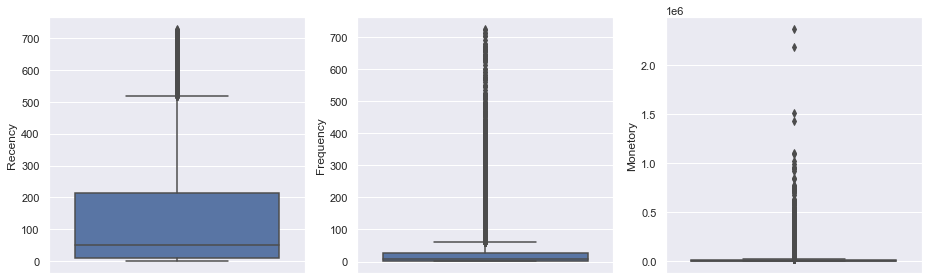

In [340]:
#Checking distribution - Boxplot
plt.figure(figsize=(13, 4))
plt.subplot(1,3,1)
sns.boxplot(y = rfm_df['Recency'])
plt.subplot(1,3,2)
sns.boxplot(y = rfm_df['Frequency'])
plt.subplot(1,3,3)
sns.boxplot(y = rfm_df['Monetory'])
plt.tight_layout()
plt.show()

The outliers are present in Recency where recency>500

In [341]:
rfm_df[rfm_df['Recency'] > 500]

,merchant,Recency,Frequency,Monetory
0,0002b63b92,594,1,33.79
2,00057d4302,514,2,295.21
3,000bcff341,509,1,78.26
4,000ddbf0ca,577,1,102.99
18,0052daeb66,520,2,173.93
...,...,...,...,...
14259,fe9bf14103,509,1,2.09
14268,fec65ccf26,520,3,144.41
14282,fef11ef166,653,2,420.82
14338,ffaeb2e3ce,652,1,53.44


The outliers are present in Frequency where frequency>100

In [343]:
rfm_df[rfm_df['Frequency'] > 100]

,merchant,Recency,Frequency,Monetory
6,000f8c3297,1,148,34551.91
19,00575c7901,0,363,679357.27
21,005e8bb6fb,72,314,988351.70
35,00a6d31535,1,211,62278.33
55,010749c732,324,201,25060.03
...,...,...,...,...
14297,ff27d3322a,5,232,11435.06
14313,ff641d59fd,8,126,36088.23
14314,ff66c68d69,0,142,65155.52
14328,ff86f631bd,0,313,328640.57


The outliers are present in Monetory where monetory>100000

In [346]:
rfm_df[rfm_df['Monetory'] > 100000]

,merchant,Recency,Frequency,Monetory
19,00575c7901,0,363,679357.27
21,005e8bb6fb,72,314,988351.70
106,01d2ab2ec4,11,31,111770.81
118,0221b4736b,49,186,119334.06
139,0294660a13,226,6,120094.95
...,...,...,...,...
14263,fea524adfd,0,463,747617.51
14287,ff068b115a,1,258,229886.77
14294,ff2221ba77,1,161,208877.78
14328,ff86f631bd,0,313,328640.57


<li> There are 939 merchants with outliers in recency. We will cap these merchant's recency with 500. </li> 
<li> There are 1280 merchants with outliers in recency. We will cap these merchant's frequency with 100. </li> 
<li> There are 499 merchants with outliers in recency. We will cap these merchant's monetory with 100,000. </li> 

In [349]:
rfm_df.loc[rfm_df['Recency'] > 500, 'Recency'] = 500
rfm_df.loc[rfm_df['Frequency'] > 100, 'Frequency'] = 100
rfm_df.loc[rfm_df['Monetory'] > 100000, 'Monetory'] = 100000

Now, we will again check the boxplots for these metrics to check the outliers

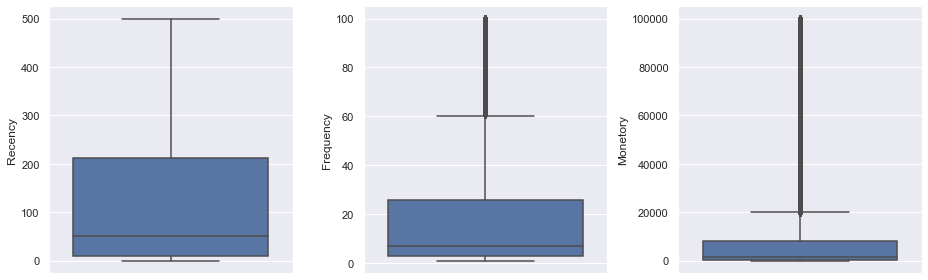

In [350]:
#Checking distribution - Boxplot
plt.figure(figsize=(13, 4))
plt.subplot(1,3,1)
sns.boxplot(y = rfm_df['Recency'])
plt.subplot(1,3,2)
sns.boxplot(y = rfm_df['Frequency'])
plt.subplot(1,3,3)
sns.boxplot(y = rfm_df['Monetory'])
plt.tight_layout()
plt.show()

There are no outliers present in the dataset. We can move ahead with the analysis.

To see summary statistics of the dataset

In [352]:
rfm_df.describe()

,Recency,Frequency,Monetory
count,14351.000000,14351.000000,14351.000000
mean,130.995610,22.452512,10952.436861
std,159.082583,30.924234,22711.840598
min,0.000000,1.000000,2.010000
25%,10.000000,3.000000,362.630000
50%,51.000000,7.000000,1602.620000
75%,213.000000,26.000000,8230.995000
max,500.000000,100.000000,100000.000000


### 3.Merchant segmentation

Feature generation

In addition to recency, frequency and monetary variables from RFM approach, we can add a couple of more variables for this approach:

   <ol>
<li> Number of days since merchant (First order date - Lastdate)</li>
<li>Average gap between 2 transactions</li>
<li>Average unit price of product bought</li>
  </ol>
  
  
Reasoning for new variables:
</ol>
<li>There can be 2 different merchants with same recency, frequency and monetary values but one is an old merchant who orders after more interval of time, and other can be a new merchant who has ordered a lot in less time period. These 2 variables will help separate these merchants from each other.</li>
<li>Although monetary variable does give a picture of monetary value of merchant, adding average unit price will help separate merchant who buy high quantity cheap items and those who buy low quantity expensive items.</li>
</ol>

In [355]:
#Creating df for merchant since days
#rfm_df=rfm_df.set_index('merchant')
data['date']=pd.to_datetime(data['date'])
MerctSinceDf = pd.DataFrame(data.groupby(['merchant']).agg({'date': lambda x : (x.max() - x.min()).days})).reset_index()

In [356]:
#Creating df for average unit price
AvgUPDf = pd.DataFrame(data.groupby(['merchant'])['usd'].mean()).reset_index()

In [357]:
#Creating variable: average 

#Extracting unique InvoiceNo, CustomerID and Date - to get date of order at merchant level
AvgGap1 = data[[ 'merchant', 'date']].drop_duplicates().sort_values(by = ['merchant', 'date'])

#Adding lag column for Date, will use this for finding difference between dates of two orders of a customer
AvgGap1['date2'] = AvgGap1.groupby(['merchant'])['date'].shift(1)

#Dropping NAs
AvgGap1.dropna(inplace = True)

#Calculating difference between consecutive order dates
AvgGap1['DateDiff'] = (AvgGap1['date'] - AvgGap1['date2'])/np.timedelta64(1,'D')

#Getting average difference between 2 orders for every customer
AvgGap = pd.DataFrame(AvgGap1.groupby(['merchant'])['DateDiff'].mean()).reset_index()

#Note: There will be some merchants missing from AvgGap table. These are the ones who ordered just once during their tenure.
#After joining with other tables, we can impute its value as a large number(representing huge amount of time between 2 orders)

In [358]:
#Merging all tables to get desired DataFrame
RFMOC = rfm_df.merge(MerctSinceDf, on='merchant')
RFMOCCS = RFMOC.merge(AvgUPDf, on = 'merchant')
KMeansDf = RFMOCCS.merge(AvgGap, on = 'merchant', how = 'left')

#Renaming columns
KMeansDf.rename(columns = { 'Date': 'MerchSince', 
                            'usd': 'AvgUP', 'DateDiff': 'GapbwOrders'}, inplace = True)
KMeansDf

,merchant,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders
0,0002b63b92,500,1,33.79,0,33.790000,NaN
1,0002d07bba,16,4,892.78,65,223.195000,21.666667
2,00057d4302,500,2,295.21,66,10.543214,66.000000
3,000bcff341,500,1,78.26,0,78.260000,NaN
4,000ddbf0ca,500,1,102.99,0,102.990000,NaN
...,...,...,...,...,...,...,...
14346,ffd3e45675,500,5,726.26,23,145.252000,5.750000
14347,ffe1f6b51a,315,47,2816.16,260,53.135094,5.652174
14348,ffe26b900d,40,66,9591.13,334,118.409012,5.138462
14349,ffec05edb9,320,3,159.34,20,53.113333,10.000000


In [359]:
#Checking Nulls in KMeansDf
KMeansDf.isna().sum()

merchant          0
Recency           0
Frequency         0
Monetory          0
date              0
AvgUP             0
GapbwOrders    1975
dtype: int64

In [360]:
data['date'].max()-data['date'].min()

Timedelta('729 days 00:00:00')

As expected nulls are present only in GapbwOrders column. We can replace these nulls by 729 (Larger than date range of dataset).

Missing value treatment

In [361]:
#Replacing nulls in dataset
KMeansDf.fillna(729, inplace = True)
KMeansDf.head()

,merchant,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders
0,0002b63b92,500,1,33.79,0,33.790000,729.000000
1,0002d07bba,16,4,892.78,65,223.195000,21.666667
2,00057d4302,500,2,295.21,66,10.543214,66.000000
3,000bcff341,500,1,78.26,0,78.260000,729.000000
4,000ddbf0ca,500,1,102.99,0,102.990000,729.000000


Outlier detection

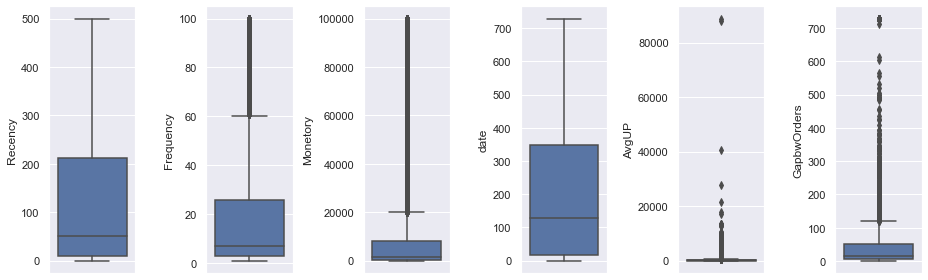

In [362]:
#Checking distribution - Boxplot
plt.figure(figsize=(13, 4))
plt.subplot(1,6,1)
sns.boxplot(y = KMeansDf['Recency'])
plt.subplot(1,6,2)
sns.boxplot(y = KMeansDf['Frequency'])
plt.subplot(1,6,3)
sns.boxplot(y = KMeansDf['Monetory'])
plt.subplot(1,6,4)
sns.boxplot(y = KMeansDf['date'])
plt.subplot(1,6,5)
sns.boxplot(y = KMeansDf['AvgUP'])
plt.subplot(1,6,6)
sns.boxplot(y = KMeansDf['GapbwOrders'])
plt.tight_layout()
plt.show()

AvgUP can be looked into for extreme outlier value.

In [364]:
KMeansDf[KMeansDf['AvgUP'] > 10000]

,merchant,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders
291,0517835bfd,79,4,71681.88,199,17920.470000,66.333333
459,0838e4078e,149,3,100000.00,97,87819.843333,48.500000
2156,26f51e4c7e,164,3,100000.00,41,27630.062500,20.500000
3694,42229128c1,500,1,40475.21,0,40475.210000,729.000000
4384,4e5d7ec3de,40,3,86595.03,145,21648.757500,72.500000
5311,5fe7751b6f,32,3,38551.81,120,12850.603333,60.000000
5658,6621bcd6c8,19,2,40254.63,557,13418.210000,557.000000
6909,7bf1cc237a,319,2,21023.02,6,10511.510000,6.000000
8357,9593c6ea3a,104,9,100000.00,523,13335.663636,65.375000
8544,9865dca5a3,31,1,13128.20,0,13128.200000,729.000000


GapbwOrders can be looked into for extreme outlier value.

In [365]:
KMeansDf[KMeansDf['GapbwOrders'] > 600]

,merchant,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders
0,0002b63b92,500,1,33.79,0,33.790000,729.0
3,000bcff341,500,1,78.26,0,78.260000,729.0
4,000ddbf0ca,500,1,102.99,0,102.990000,729.0
7,001f7b7a4f,304,1,64.44,0,64.440000,729.0
22,00607c6461,10,1,500.94,0,500.940000,729.0
...,...,...,...,...,...,...,...
14288,ff0c1adfdd,328,1,339.22,0,339.220000,729.0
14305,ff52328395,4,1,1712.21,0,1712.210000,729.0
14331,ff9135ed50,31,1,188.24,0,188.240000,729.0
14334,ff98eee16c,325,1,480.41,0,10.008542,729.0


We can cap the AvgUP value for outlier merchants as 10000 and cap the GapbwOrders value for outlier merchants as 600.

In [367]:
KMeansDf.loc[KMeansDf['AvgUP'] > 10000, 'AvgUP'] = 10000
KMeansDf.loc[KMeansDf['GapbwOrders'] > 600, 'GapbwOrders'] = 600

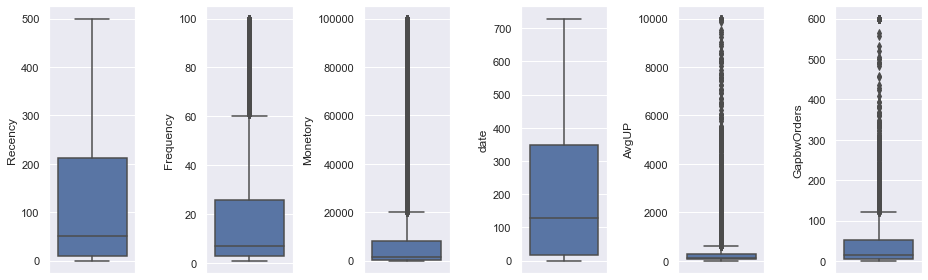

In [368]:
#Checking distribution - Boxplot
plt.figure(figsize=(13, 4))
plt.subplot(1,6,1)
sns.boxplot(y = KMeansDf['Recency'])
plt.subplot(1,6,2)
sns.boxplot(y = KMeansDf['Frequency'])
plt.subplot(1,6,3)
sns.boxplot(y = KMeansDf['Monetory'])
plt.subplot(1,6,4)
sns.boxplot(y = KMeansDf['date'])
plt.subplot(1,6,5)
sns.boxplot(y = KMeansDf['AvgUP'])
plt.subplot(1,6,6)
sns.boxplot(y = KMeansDf['GapbwOrders'])
plt.tight_layout()
plt.show()

Checking correlation between different variables:

<AxesSubplot:>

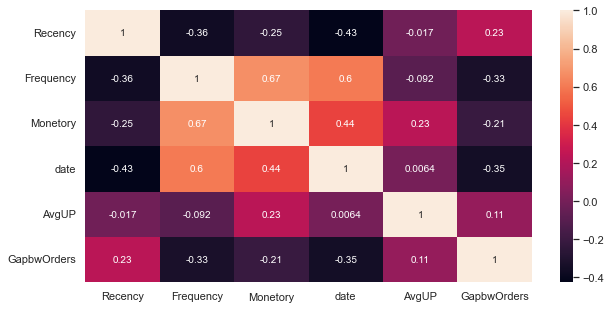

In [370]:
corrMatrix = KMeansDf.corr()
sns.heatmap(corrMatrix, annot=True)

There is significant correlation between:

<ol>
<li>Monetary and Frequency</li>
<li>date and Frequency</li>
</ol>

Both of these are expected. Frequency of ordering being the causation for both.
We don't need to remove any variable as all 3 add value to the process.

Feature scaling: 
Scaling should be performed before Clustering to cancel out the effect of different range of continuous variables and bring all variables to a same scale

In [371]:
KMeansDf=KMeansDf.set_index('merchant')
#Standardizing the features
KMeansScaledDf = StandardScaler().fit_transform(KMeansDf)

**Principal Component Analysis**
PCA is a form of dimensionality reduction technique deployed to reduce number of features to be used for any machine learning algorithm. It helps improve data compression and reduce computation time. Also, it will help to visualize clusters better.

In [372]:
#Importing PCA package
from sklearn.decomposition import PCA

#Setting threshold of variation to be considered for selecting principal components as 95%
pca = PCA(0.95)

#Performing PCA
principalComponents = pca.fit_transform(KMeansScaledDf)

In [373]:
principalComponents

array([[-2.77023217,  0.62165383,  1.81193753, -1.23065033,  0.59507659],
       [-0.45179664, -0.45803536, -0.88881435,  0.25061821, -0.65615112],
       [-1.70888421, -0.38875031,  1.56527636,  0.9721566 ,  0.46011658],
       ...,
       [ 1.42407837, -0.56943195, -0.00892524, -0.20000503,  0.1009733 ],
       [-1.29196811, -0.51861728,  0.66330678,  0.87259168, -0.16900201],
       [ 1.00377546, -0.61266259, -0.83359325, -0.12787109,  0.95979629]])

Number of features have been reduced from 6 to 5. Not a significant change, but features are now arranged in order of value add to entire data variation. It will help visualize the clusters better.

In [374]:
#Storing PC into a dataframe
principalDf = pd.DataFrame(data = principalComponents
            , columns = ['principal component 1', 'principal component 2',
                         'principal component 3', 'principal component 4',
                         'principal component 5'])

Clustering Tendency

In [375]:
#Importing required packages and defining function for clustering tendency
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [376]:
hopkins(principalDf)

0.9672969131244689

Dataset has great tendency to be clustered. (Values above 0.7 are good)

 Optimal number of clusters k

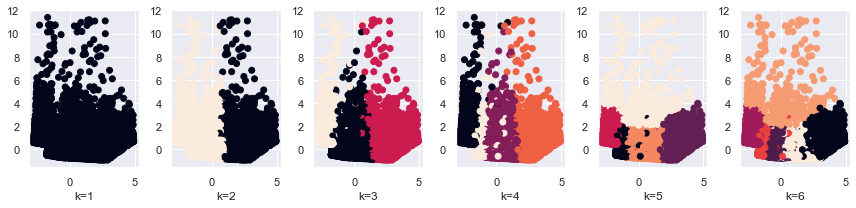

In [377]:
#Plotting data across 2 components and 1:6 clusters to visualize how the clusters will look for different values of k
plt.figure(figsize=(12, 3))
for k in range(1,7):
    kmeans = KMeans(n_clusters=k)
    a = kmeans.fit_predict(principalDf)
    plt.subplot(1,6,k)
    plt.scatter(principalDf.iloc[:,0], principalDf.iloc[:,1], c=a)
    plt.xlabel('k='+str(k))
plt.tight_layout()
plt.show()

In [378]:
#Creating inertias and distrotion values for different values of k
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,10)

for k in K:
#Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(principalDf)
    kmeanModel.fit(principalDf)

    distortions.append(sum(np.min(cdist(principalDf, kmeanModel.cluster_centers_,
    'euclidean'),axis=1)) / rfm_df.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(principalDf, kmeanModel.cluster_centers_,
    'euclidean'),axis=1)) / principalDf.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [379]:
for key,val in mapping1.items():
    print(str(key)+' : '+str(val))

1 : 2.0948871011560795
2 : 1.7586803741069115
3 : 1.4749087373305736
4 : 1.2632017536842741
5 : 1.1866214724616346
6 : 1.0257709938578587
7 : 0.9540951201216766
8 : 0.9255792925891559
9 : 0.8628296532605451


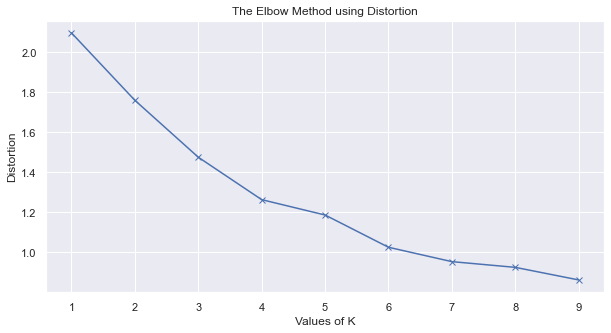

In [380]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [381]:
for key,val in mapping2.items():
    print(str(key)+' : '+str(val))

1 : 82750.60013473727
2 : 57675.240116130444
3 : 42894.31008652093
4 : 34191.016775411816
5 : 26153.55762456562
6 : 20859.334842462325
7 : 18284.965784965607
8 : 16248.449875036604
9 : 14404.458565429051


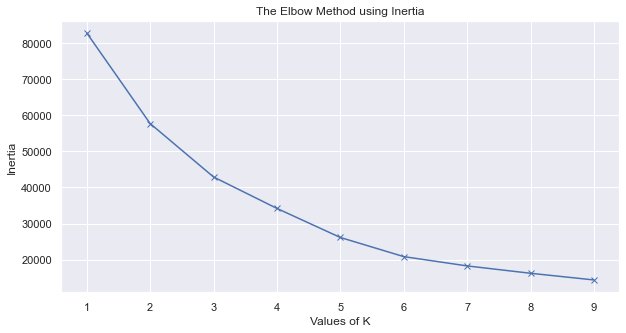

In [382]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Ideally there should be a bend across the elbow curve and we select that value of k as optimal value.
Looking at these curves, we can select a high value of k = 5 as optimal value, but that will cause very few number of data points in some cluster (visible from subplots above) and does not make business sense.
Hence we can select next best value for k, i.e k = 3

Clustering

In [385]:
#Performing clustering
kmeans = KMeans(n_clusters=3)
KMeans_out = pd.DataFrame(kmeans.fit_predict(principalDf))
KMeans_out.columns = ['Cluster']

Cluster Validation

In [387]:
#Importing required packages and defining function for Dunn Index
from sklearn.metrics.pairwise import euclidean_distances

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000

    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])

    return np.min(values)

def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])

    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])

    return np.max(values)

def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
    A list containing a numpy array for each cluster |c| = number of clusters
    c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))

    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
    
        big_deltas[k] = big_delta(k_list[k])
    
    di = np.min(deltas)/np.max(big_deltas)
    return di

In [388]:
#Making index of PCA and KMeans_out same
KMeans_out.index = principalDf.index

#Concatting both dataframes
prediction = pd.concat([principalDf, KMeans_out], axis = 1) 

#Storing cluster outputs in different data sets and making a list from them
clus0 = prediction.loc[prediction.Cluster == 0] 
clus1 = prediction.loc[prediction.Cluster == 1] 
clus2 = prediction.loc[prediction.Cluster == 2] 
#cluster_list = [clus0.values, clus1.values, clus2.values]

#print(dunn(cluster_list)) - Kernel was running this for longer time, I still need to deep-dive into this

Cluster Definition

In [390]:
#Joining clustering output with base dataset
KMeans_out.index = KMeansDf.index
KMeans_out_df = pd.concat([KMeansDf, KMeans_out], axis = 1)

In [391]:
from IPython.display import display
display('Cluster 0',KMeans_out_df.loc[KMeans_out_df['Cluster'] == 0].describe())
display('Cluster 1',KMeans_out_df.loc[KMeans_out_df['Cluster'] == 1].describe())
display('Cluster 2',KMeans_out_df.loc[KMeans_out_df['Cluster'] == 2].describe())

'Cluster 0'

,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster
count,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.0
mean,222.288068,1.013979,880.943879,6.093859,573.096478,597.580130,0.0
std,176.583240,0.117433,2683.727640,55.128088,1304.926469,27.837655,0.0
min,0.000000,1.000000,2.010000,0.000000,2.010000,6.000000,0.0
25%,55.000000,1.000000,74.310000,0.000000,61.195000,600.000000,0.0
50%,190.000000,1.000000,197.950000,0.000000,153.530000,600.000000,0.0
75%,384.500000,1.000000,574.365000,0.000000,421.590000,600.000000,0.0
max,500.000000,2.000000,51494.250000,724.000000,10000.000000,600.000000,0.0


'Cluster 1'

,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster
count,9804.000000,9804.000000,9804.000000,9804.000000,9804.000000,9804.000000,9804.0
mean,140.571093,12.232048,3726.508808,174.681355,284.338464,29.419715,1.0
std,158.024289,13.354576,6500.955423,169.283978,590.041167,43.006413,0.0
min,0.000000,2.000000,4.120000,1.000000,2.060000,1.000000,1.0
25%,16.000000,3.000000,398.237500,33.000000,54.607444,5.500000,1.0
50%,69.000000,7.000000,1279.825000,118.000000,98.142375,14.548611,1.0
75%,229.000000,16.000000,3990.725000,281.000000,225.477500,34.366477,1.0
max,500.000000,100.000000,87229.070000,722.000000,10000.000000,409.000000,1.0


'Cluster 2'

,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster
count,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.0
mean,22.215409,78.719340,46729.244674,449.788522,502.197896,7.206422,2.0
std,56.924293,27.873835,34358.683276,165.094163,1080.013689,12.267704,0.0
min,0.000000,2.000000,463.510000,1.000000,2.460000,1.000000,2.0
25%,1.000000,60.000000,16840.535000,330.000000,70.633744,2.036146,2.0
50%,3.000000,100.000000,35615.535000,462.000000,144.235195,3.910645,2.0
75%,14.000000,100.000000,81219.892500,582.250000,394.569228,7.825658,2.0
max,500.000000,100.000000,100000.000000,729.000000,10000.000000,223.333333,2.0


**Merchant Segments:**
<ol>
<li>One time Merchants (Cluster 0): These are the Merchants who: </li>
<ol>    
<li>Shopped once and did not come back</li>
<li>Did not shop recently</li>
<li>Very less revenue contributors</li>
 <li>Less tenure with stripe</li>
    <li>Gap between consecutive transactions is very large</li>
<li>Constitute around 14% of total merchant base</li>
    </ol>

<li>Active Merchants (Cluster 1): These are the Merchants who:</li>
    <ol>
<li>Shopped often and frequently</li>
<li>Contributed less to  overall revenue</li>
 <li>On an avg 6 months tenure with stripe</li>
        <li>On an avg 1 month time difference between the consecutive transactions</li>
<li>Constitute ~68% of all customers</li>
    </ol>
    
<li>Loyal Merchants (Cluster 2): These are the Merchants who:</li>
    <ol>
<li>Shopped very often and frequently</li>
        <li>Did shop recently</li>
<li>Contributed huge to  overall revenue</li>
        <li>Longer tenure with stripe</li>
         <li>Gap between consecutive transactions is very less</li>
<li>Constitute ~18% of all customers</li>
    </ol>
</ol>

### 4.Merchant churn analysis

For churn analysis, we will not consider the Cluster 0 as they have made ver less transactions in given 2 years and it does not make sense to analyze their behaviour in terms of churn analysis. We can understand their trend separately. 

Checking the recency trend for cluster 1

<AxesSubplot:xlabel='Recency'>

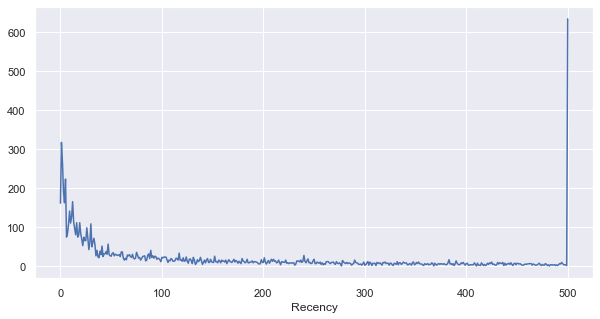

In [392]:
KMeans_out_df.loc[KMeans_out_df['Cluster']==1].groupby(['Recency'])['Recency'].count().plot(kind = 'line')

Since, the mean of gap of consecutive orders for cluster 1 is aorund 30 days. We can say that merchants with recency <30 can make transaction in upcoming days, so we can remove them.

Checking the frequency trend for cluster 1

<AxesSubplot:xlabel='Frequency'>

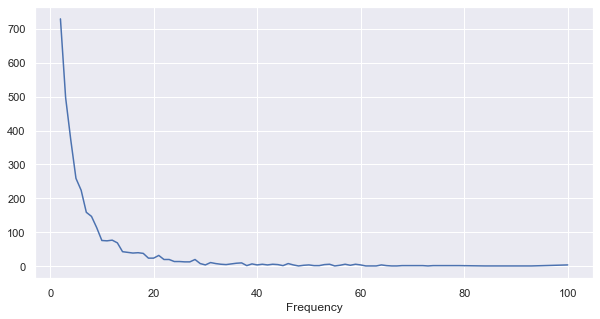

In [478]:
KMeans_out_df.loc[(KMeans_out_df['Cluster']==1) & (KMeans_out_df['Recency']>150)].groupby(['Frequency'])['Frequency'].count().plot(kind = 'line')

Checking the Gap between orders trend for cluster 1

<AxesSubplot:xlabel='GapbwOrders'>

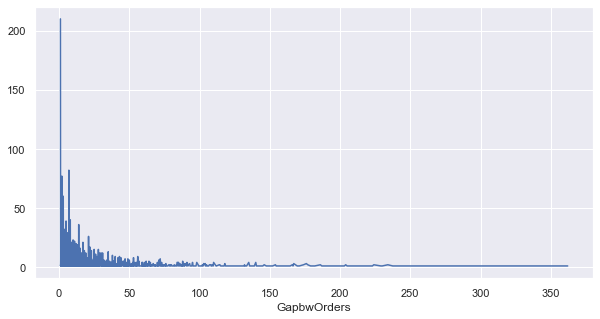

In [480]:
KMeans_out_df.loc[(KMeans_out_df['Cluster']==1) & (KMeans_out_df['Recency']>150)].groupby(['GapbwOrders'])['GapbwOrders'].count().plot(kind = 'line')

For cluster 1, if the merchant has not made any transaction in recent 60 days, if his mean gap between orders is less than 30 days (intution: if merchant stopped making transaction with stripe, his recency will increase and since he was an active customer before his reecency will be more than the avg gap between the orders) and merchants who have made atleast 3 transactions, then we will tag the merchant to be churned.

In [482]:
model_df=KMeans_out_df.loc[(KMeans_out_df['Cluster']==1) & (KMeans_out_df['Recency']>60)& (KMeans_out_df['GapbwOrders']<30) & (KMeans_out_df['Frequency']>4)]
model_df['churn']=1
model_df

C:\Users\apoor\AppData\Local\Temp/ipykernel_15940/3029566892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['churn']=1


,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster,churn
merchant,,,,,,,,
0026f256ac,472,8,2508.78,89,313.597500,12.714286,1,1
0042aadfdf,200,54,8069.78,105,56.040139,1.981132,1,1
004a994585,70,14,3715.72,195,265.408571,15.000000,1,1
004d02cb10,423,23,13422.72,134,432.990968,6.090909,1,1
0082de98e9,168,9,965.51,26,53.639444,3.250000,1,1
...,...,...,...,...,...,...,...,...
ff8f964b25,225,16,595.59,322,29.779500,21.466667,1,1
ffa96a4f57,126,10,4671.37,26,311.424667,2.888889,1,1
ffc46fd720,205,6,200.58,70,33.430000,14.000000,1,1


For cluster 1, if the merchant has  made any transaction in recent 360 days and merchants who have made atleast 3 transactions, then we will tag the merchant to be not churned.

In [459]:
clust1_nc=KMeans_out_df.loc[(KMeans_out_df['Cluster']==1) & (KMeans_out_df['Recency']<=60)& (KMeans_out_df['Frequency']>4)]
clust1_nc['churn']=0
clust1_nc

C:\Users\apoor\AppData\Local\Temp/ipykernel_15940/3543603398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust1_nc['churn']=0


,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster,churn
merchant,,,,,,,,
003d24c5d3,22,5,677.01,140,84.626250,35.000000,1,0
003d5fe4f1,6,9,1033.65,110,114.850000,13.750000,1,0
0063ff0c6b,41,13,10961.74,479,391.490714,39.916667,1,0
008a9c02f1,26,6,14811.02,124,2468.503333,24.800000,1,0
008c7ea5b2,2,44,4619.77,295,94.281020,6.860465,1,0
...,...,...,...,...,...,...,...,...
ff9a41fb99,41,5,411.82,48,82.364000,12.000000,1,0
ffab12577a,12,17,4371.43,288,230.075263,18.000000,1,0
ffc99ae470,5,26,8829.08,364,339.580000,14.560000,1,0


Checking the recency trend for cluster 2

<AxesSubplot:xlabel='Recency'>

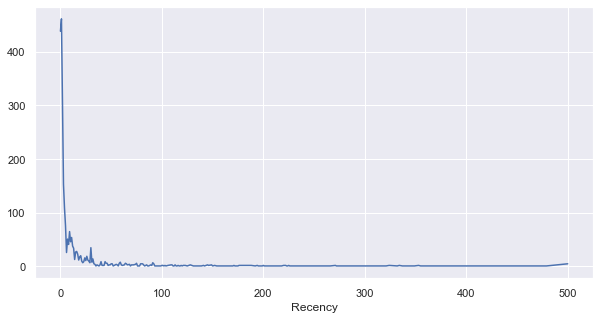

In [408]:
KMeans_out_df.loc[KMeans_out_df['Cluster']==2].groupby(['Recency'])['Recency'].count().plot(kind = 'line')

Since, the mean of gap of consecutive orders for cluster 1 is aorund 7 days. We can say that merchants with recency <7 can make transaction in upcoming days, so we can remove them.

Checking the frequency trend for cluster 2

<AxesSubplot:xlabel='Frequency'>

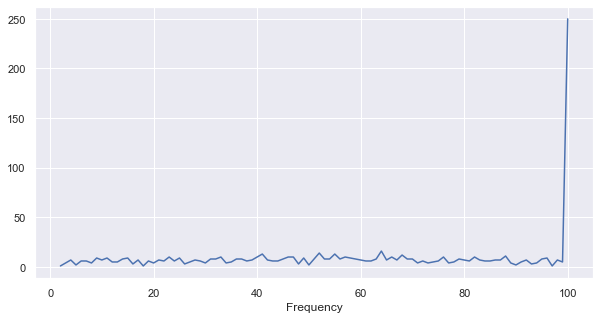

In [412]:
KMeans_out_df.loc[(KMeans_out_df['Cluster']==2) & (KMeans_out_df['Recency']>7)].groupby(['Frequency'])['Frequency'].count().plot(kind = 'line')

Checking the Gap between orders trend for cluster 2

<AxesSubplot:xlabel='GapbwOrders'>

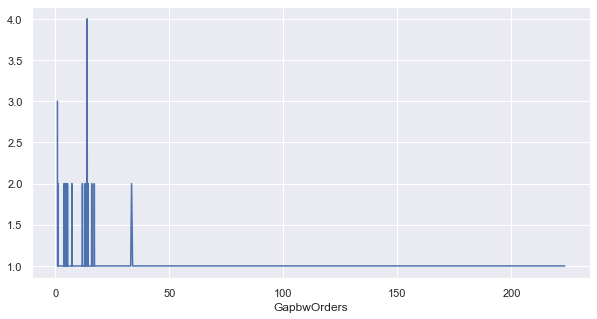

In [415]:
KMeans_out_df.loc[(KMeans_out_df['Cluster']==2) & (KMeans_out_df['Recency']>7)].groupby(['GapbwOrders'])['GapbwOrders'].count().plot(kind = 'line')

For cluster 2, if the merchant has not made any transaction in recent 30 days, if his mean gap between orders is less than 7 days (intution: if merchant stopped making transaction with stripe, his recency will increase and since he was an active customer before his reecency will be more than the avg gap between the orders) and merchants who have made atleast 3 transactions, then we will tag the merchant to be churned.

In [460]:
clust2_c=KMeans_out_df.loc[(KMeans_out_df['Cluster']==2) & (KMeans_out_df['Recency']>30)& (KMeans_out_df['GapbwOrders']<7) & (KMeans_out_df['Frequency']>4)]
clust2_c['churn']=1
clust2_c

C:\Users\apoor\AppData\Local\Temp/ipykernel_15940/1171292380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust2_c['churn']=1


,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster,churn
merchant,,,,,,,,
005e8bb6fb,72,100,100000.00,518,205.009687,1.654952,2,1
010749c732,324,100,25060.03,321,67.185067,1.605000,2,1
013a169f1e,64,100,62074.25,319,61.888584,1.910180,2,1
0221b4736b,49,100,100000.00,468,49.763995,2.529730,2,1
0294660a13,226,6,100000.00,16,1559.674675,3.200000,2,1
...,...,...,...,...,...,...,...,...
fa59864e12,254,100,24041.03,293,84.059545,2.421488,2,1
fa7d245ebd,414,7,100000.00,7,302.762811,1.166667,2,1
fb756b5acc,154,100,7120.35,520,45.643269,4.227642,2,1


For cluster 2, if the merchant has  made any transaction in recent 30 days and merchants who have made atleast 3 transactions, then we will tag the merchant to be not churned.

In [461]:
clust2_nc=KMeans_out_df.loc[(KMeans_out_df['Cluster']==2) & (KMeans_out_df['Recency']<=30)& (KMeans_out_df['Frequency']>4)]
clust2_nc['churn']=0
clust2_nc

C:\Users\apoor\AppData\Local\Temp/ipykernel_15940/2656205561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust2_nc['churn']=0


,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster,churn
merchant,,,,,,,,
000ed1585f,25,58,16472.67,656,265.688226,11.508772,2,0
000f8c3297,1,100,34551.91,457,119.144517,3.108844,2,0
002a66c0e1,3,74,35551.51,350,348.544216,4.794521,2,0
00575c7901,0,100,100000.00,362,68.900332,1.000000,2,0
008d1671e6,10,65,27363.17,401,307.451348,6.265625,2,0
...,...,...,...,...,...,...,...,...
ff66c68d69,0,100,65155.52,426,298.878532,3.021277,2,0
ff7de3999b,26,10,41857.52,427,4185.752000,47.444444,2,0
ff80602381,1,64,36606.09,182,197.870757,2.888889,2,0


Merging all created datasets

In [462]:
final_model_df=pd.concat([model_df,clust1_nc,clust2_c, clust2_nc],ignore_index=True)
final_model_df

,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster,churn
0,472,8,2508.78,89,313.597500,12.714286,1,1
1,200,54,8069.78,105,56.040139,1.981132,1,1
2,70,14,3715.72,195,265.408571,15.000000,1,1
3,423,23,13422.72,134,432.990968,6.090909,1,1
4,168,9,965.51,26,53.639444,3.250000,1,1
...,...,...,...,...,...,...,...,...
8120,0,100,65155.52,426,298.878532,3.021277,2,0
8121,26,10,41857.52,427,4185.752000,47.444444,2,0
8122,1,64,36606.09,182,197.870757,2.888889,2,0
8123,0,100,100000.00,312,59.278602,1.000000,2,0


To see the frequency trend for non-churned merchants

<AxesSubplot:xlabel='Frequency'>

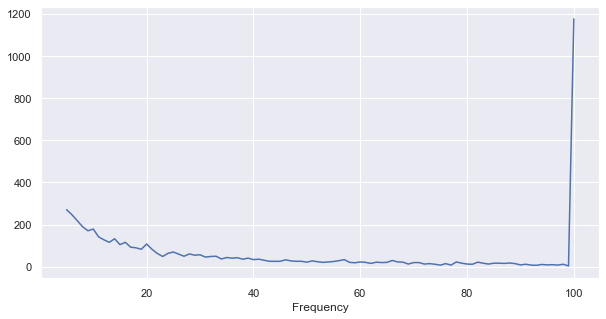

In [513]:
final_model_df.loc[final_model_df['churn'] == 0].groupby(['Frequency'])['Frequency'].count().plot(kind = 'line')

To see the frequency trend for churned merchants

<AxesSubplot:xlabel='Frequency'>

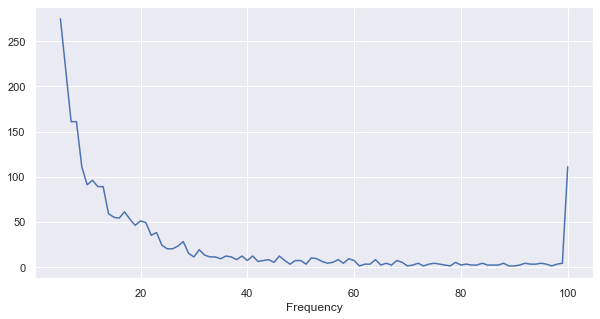

In [514]:
final_model_df.loc[final_model_df['churn'] == 1].groupby(['Frequency'])['Frequency'].count().plot(kind = 'line')

Most of the churned merchants did make the 1-20 transactions in 2 years

To see the consecutive transaction gap for churned merchants

<AxesSubplot:xlabel='GapbwOrders'>

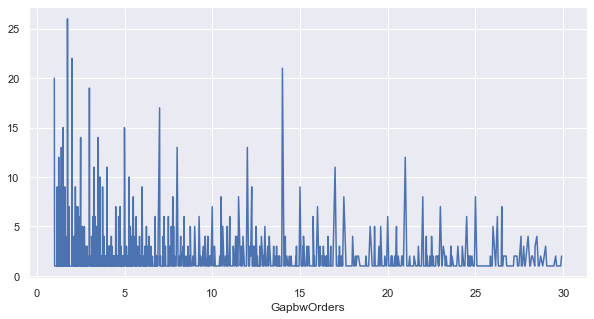

In [516]:
final_model_df.loc[(final_model_df['churn']==1)].groupby(['GapbwOrders'])['GapbwOrders'].count().plot(kind = 'line')

To see the consecutive transaction gap for non churned merchants

<AxesSubplot:xlabel='GapbwOrders'>

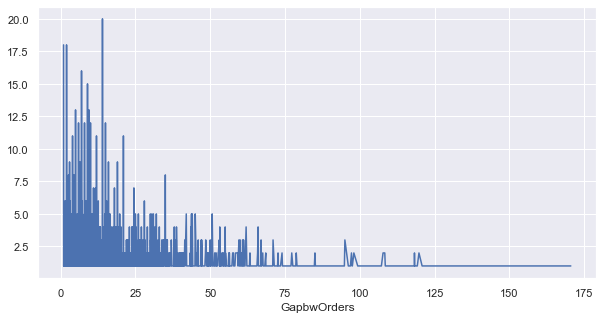

In [517]:
final_model_df.loc[(final_model_df['churn']==0)].groupby(['GapbwOrders'])['GapbwOrders'].count().plot(kind = 'line')

Most of the churned merchants are uniformly distributed across 0 to 14 consecutive transaction gap while non churned merchants are left skewed from 0 to 25 gap days

**Prediction of merchant churn**

In [463]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [464]:
df_final = final_model_df.apply(lambda x: object_to_int(x))
df_final.head()

,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders,Cluster,churn
0,472,8,2508.78,89,313.597500,12.714286,1,1
1,200,54,8069.78,105,56.040139,1.981132,1,1
2,70,14,3715.72,195,265.408571,15.000000,1,1
3,423,23,13422.72,134,432.990968,6.090909,1,1
4,168,9,965.51,26,53.639444,3.250000,1,1


In [465]:
X = df_final.drop(columns = ['churn','Cluster'])
y = df_final['churn'].values
X

,Recency,Frequency,Monetory,date,AvgUP,GapbwOrders
0,472,8,2508.78,89,313.597500,12.714286
1,200,54,8069.78,105,56.040139,1.981132
2,70,14,3715.72,195,265.408571,15.000000
3,423,23,13422.72,134,432.990968,6.090909
4,168,9,965.51,26,53.639444,3.250000
...,...,...,...,...,...,...
8120,0,100,65155.52,426,298.878532,3.021277
8121,26,10,41857.52,427,4185.752000,47.444444
8122,1,64,36606.09,182,197.870757,2.888889
8123,0,100,100000.00,312,59.278602,1.000000


Spliting dataset with 60%-40% of train and test split

In [488]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.40, random_state = 40, stratify=y)

In [489]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)

Logistic Regression accuracy is : 0.9667692307692307


C:\Users\apoor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
